<a href="https://colab.research.google.com/github/Y-Noor/JAX/blob/main/logistic_regression/flax_linen_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Logistic regression for Titanic competition on Kaggle https://www.kaggle.com/competitions/titanic

Scikit-Learn is used for ease of implementation of training/testing split as well as metrics for the model

This script implements an end-to-end binary classification pipeline for the Titanic dataset using JAX and Flax. It leverages JAX's JIT compilation for high-performance training on GPU/TPU while integrating Scikit-Learn for robust stratified data splitting and comprehensive metric evaluation (Accuracy, F1, ROC-AUC).

In [45]:
import pandas as pd

In [46]:
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [47]:
def clean(data):
    data = data.drop(["Ticket", "Cabin", "Name", "PassengerId"], axis=1)

    cols = ["SibSp", "Parch", "Fare", "Age"]
    for col in cols:
        data[col].fillna(data[col].median(), inplace=True)

    data.Embarked.fillna("U", inplace=True)
    return data

In [48]:
data = clean(data)
test = clean(test)

/tmp/ipython-input-3605458426.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace=True)
/tmp/ipython-input-3605458426.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

In [49]:
data.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [ ]:
cols = ["Sex", "Embarked"]

In [51]:
import jax.numpy as jnp
from jax import nn
import pandas as pd
import numpy as np

def get_category_mappings(dfs, cols):
    """
    Creates a consistent mapping dictionary for specified columns based on
    unique values found across all provided DataFrames (e.g., train and test).

    Args:
        dfs: List of DataFrames (e.g., [train_df, test_df])
        cols: List of column names to encode

    Returns:
        dict: A dictionary where keys are column names and values are
              tuples (category_to_int_dict, num_classes)
    """
    mappings = {}
    for col in cols:
        # Get unique values across all datasets to ensure consistency
        # Using pd.unique is faster than converting to set
        all_values = pd.concat([df[col] for df in dfs]).unique()

        # Sort to ensure deterministic column ordering
        # Handle mixed types if necessary, though usually categorical cols are strings
        try:
            all_values.sort()
        except TypeError:
            pass

        cat_to_int = {cat: i for i, cat in enumerate(all_values)}
        mappings[col] = (cat_to_int, len(all_values))

    return mappings

def jax_one_hot_encode(df, cols, mappings):
    """
    Applies JAX one-hot encoding to a DataFrame using pre-calculated mappings.
    Returns a new DataFrame with original categorical columns replaced.
    """
    encoded_dfs = []

    # 1. Process all encodings
    for col in cols:
        if col not in mappings:
            raise ValueError(f"Mapping for column '{col}' not found.")

        cat_to_int, num_classes = mappings[col]

        # Map values to integers using pandas map (efficient on CPU)
        # Fill NaN with -1 or handle appropriately; here we assume clean data
        # or that NaNs are a category in the mapping.
        int_labels = df[col].map(cat_to_int).fillna(-1).to_numpy(dtype=np.int32)

        # Move to JAX Device
        jnp_labels = jnp.array(int_labels)

        # Perform One-Hot Encoding
        # Note: nn.one_hot returns float32 by default.
        one_hot_jax = nn.one_hot(jnp_labels, num_classes=num_classes)

        # Convert back to Pandas format
        # Use np.array() to pull from JAX device back to CPU memory
        new_col_names = [f"{col}_{cat}" for cat in cat_to_int.keys()]

        # Create a temporary DataFrame for this column's features
        encoded_dfs.append(
            pd.DataFrame(np.array(one_hot_jax), columns=new_col_names, index=df.index)
        )

    # 2. Drop original columns and concatenate everything ONCE
    df_base = df.drop(columns=cols)

    # concat is expensive, so we do it only one time with all pieces
    result = pd.concat([df_base] + encoded_dfs, axis=1)

    return result

In [52]:
mappings = get_category_mappings([data, test], cols)

# 2. Transform the DataFrames
data_encoded = jax_one_hot_encode(data, cols, mappings)
test_encoded = jax_one_hot_encode(test, cols, mappings)

print("Data shape:", data_encoded.shape)
print("Test shape:", test_encoded.shape)
print(data_encoded.head())

Data shape: (891, 12)
Test shape: (418, 11)
   Survived  Pclass   Age  SibSp  Parch     Fare  Sex_female  Sex_male  \
0         0       3  22.0      1      0   7.2500         0.0       1.0   
1         1       1  38.0      1      0  71.2833         1.0       0.0   
2         1       3  26.0      0      0   7.9250         1.0       0.0   
3         1       1  35.0      1      0  53.1000         1.0       0.0   
4         0       3  35.0      0      0   8.0500         0.0       1.0   

   Embarked_C  Embarked_Q  Embarked_S  Embarked_U  
0         0.0         0.0         1.0         0.0  
1         1.0         0.0         0.0         0.0  
2         0.0         0.0         1.0         0.0  
3         0.0         0.0         1.0         0.0  
4         0.0         0.0         1.0         0.0  


In [ ]:
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
from jax import random
import flax.linen as nn
import optax
from flax.training import train_state

# Sklearn Imports (Best for Splitting & Metrics)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

# ==========================================
# 1. Model & Core JAX Logic
# ==========================================

class LogisticRegressor(nn.Module):
    @nn.compact
    def __call__(self, x):
        return nn.Dense(features=1, name="output_layer")(x)

@jax.jit
def train_step(state, batch_X, batch_y):
    """Performs one step of Gradient Descent."""
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, batch_X)
        loss = optax.sigmoid_binary_cross_entropy(logits, batch_y).mean()
        return loss

    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

def get_batches(X, y, batch_size, key):
    """Yields shuffled batches."""
    num_samples = X.shape[0]
    indices = random.permutation(key, num_samples)
    for i in range(0, num_samples, batch_size):
        batch_idx = indices[i : i + batch_size]
        yield X[batch_idx], y[batch_idx]

# ==========================================
# 2. Metric Helper
# ==========================================

def evaluate_model(state, model, X_jax, y_true_np, print_report=False):
    """
    Generates predictions on GPU, moves to CPU, and calculates metrics.
    Returns: accuracy (float), and confusion matrix (if print_report=True)
    """
    # 1. Forward Pass
    logits = model.apply({'params': state.params}, X_jax)
    probs = nn.sigmoid(logits)

    # 2. Move to Numpy
    y_probs_np = np.array(probs).flatten()
    y_pred_np = (y_probs_np >= 0.5).astype(int)
    y_true_np = np.array(y_true_np).flatten()

    # 3. Basic Accuracy
    acc = accuracy_score(y_true_np, y_pred_np)

    # 4. Detailed Report (Optional - usually for end of training)
    if print_report:
        print("\n" + "="*40)
        print(f"      FINAL METRICS (Acc: {acc:.2%})")
        print("="*40)
        print(f"Precision : {precision_score(y_true_np, y_pred_np):.4f}")
        print(f"Recall    : {recall_score(y_true_np, y_pred_np):.4f}")
        print(f"F1 Score  : {f1_score(y_true_np, y_pred_np):.4f}")
        print(f"ROC-AUC   : {roc_auc_score(y_true_np, y_probs_np):.4f}")
        print("-" * 40)
        print(classification_report(y_true_np, y_pred_np, target_names=['Died', 'Survived']))

        # Plot Confusion Matrix
        cm = confusion_matrix(y_true_np, y_pred_np)
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Died', 'Survived'], yticklabels=['Died', 'Survived'])
        plt.title('Confusion Matrix')
        plt.show()

    return acc

# ==========================================
# Training Loop
# ==========================================

def run_training(X_train, y_train, X_val, y_val, batch_size=32, epochs=100, lr=0.001):

    # Init Model
    model = LogisticRegressor()
    key = random.PRNGKey(42)
    key, init_key = random.split(key)
    params = model.init(init_key, X_train[:1])['params']

    # Init Optimizer
    optimizer = optax.adam(learning_rate=lr)
    state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)

    # Prepare Validation Targets for Sklearn (CPU)
    y_val_np = np.array(y_val)

    print(f"Starting Training on {len(X_train)} samples...")

    for epoch in range(epochs):
        key, shuffle_key = random.split(key)
        batch_losses = []

        # Batch Loop
        for batch_X, batch_y in get_batches(X_train, y_train, batch_size, shuffle_key):
            state, loss = train_step(state, batch_X, batch_y)
            batch_losses.append(loss)

        # Logging (Every 20 epochs)
        if epoch % 20 == 0 or epoch == epochs - 1:
            mean_loss = jnp.mean(jnp.array(batch_losses))
            # Quick validation check
            val_acc = evaluate_model(state, model, X_val, y_val_np, print_report=False)
            print(f"Epoch {epoch:3d} | Loss: {mean_loss:.4f} | Val Acc: {val_acc:.2%}")

    return state, model


In [ ]:

# Data Split (Sklearn)
# -----------------------
target_col = 'Survived'
X_full_np = data_encoded.drop(columns=[target_col]).values
y_full_np = data_encoded[target_col].values

X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(
    X_full_np, y_full_np, test_size=0.2, random_state=42, stratify=y_full_np
)


X_train_jax = jnp.array(X_train_np, dtype=jnp.float32)
y_train_jax = jnp.array(y_train_np, dtype=jnp.float32).reshape(-1, 1)
X_val_jax = jnp.array(X_val_np, dtype=jnp.float32)
y_val_jax = jnp.array(y_val_np, dtype=jnp.float32).reshape(-1, 1)

# Train
# -----------------------
state, model = run_training(
    X_train_jax, y_train_jax,
    X_val_jax, y_val_jax,
    batch_size=32, epochs=200, lr=0.001
)


Starting Training on 712 samples...
Epoch   0 | Loss: 6.4041 | Val Acc: 62.01%
Epoch  20 | Loss: 0.5150 | Val Acc: 76.54%
Epoch  40 | Loss: 0.4784 | Val Acc: 78.21%
Epoch  60 | Loss: 0.4694 | Val Acc: 79.33%
Epoch  80 | Loss: 0.4583 | Val Acc: 80.45%
Epoch 100 | Loss: 0.4600 | Val Acc: 80.45%
Epoch 120 | Loss: 0.4552 | Val Acc: 79.89%
Epoch 140 | Loss: 0.4628 | Val Acc: 79.89%
Epoch 160 | Loss: 0.4486 | Val Acc: 79.89%
Epoch 180 | Loss: 0.4474 | Val Acc: 79.89%
Epoch 199 | Loss: 0.4521 | Val Acc: 79.89%



      FINAL METRICS (Acc: 79.89%)
Precision : 0.7797
Recall    : 0.6667
F1 Score  : 0.7188
ROC-AUC   : 0.8362
----------------------------------------
              precision    recall  f1-score   support

        Died       0.81      0.88      0.84       110
    Survived       0.78      0.67      0.72        69

    accuracy                           0.80       179
   macro avg       0.79      0.77      0.78       179
weighted avg       0.80      0.80      0.80       179



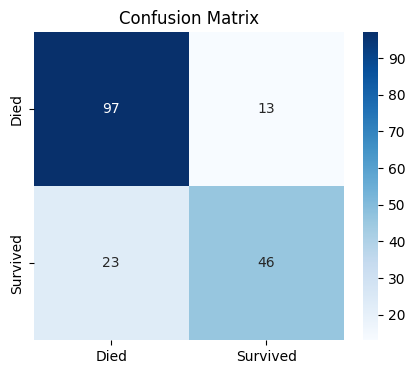

In [ ]:
evaluate_model(state, model, X_val_jax, y_val_np, print_report=True)

X_test_jax = jnp.array(test_encoded.values, dtype=jnp.float32)

# Get predictions
logits = model.apply({'params': state.params}, X_test_jax)
probs = nn.sigmoid(logits)
preds_test = (probs >= 0.5).astype(int).flatten()

In [54]:
test_original = pd.read_csv('test.csv')

# 2. Use the IDs from the fresh load
df = pd.DataFrame({
    "PassengerId": test_original['PassengerId'].values,
    "Survived": preds_test
})

# 3. Save
df.to_csv("submission.csv", index=False)